In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm # Used to display images in a specific colormap
import scipy
from scipy.io import loadmat
from scipy.optimize import minimize

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 7.0)
np.set_printoptions(suppress=True)
import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')

In [33]:
data = loadmat('data/ex8data1.mat')
X = data['X']
Xval = data['Xval']
yval = data['yval']
print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])


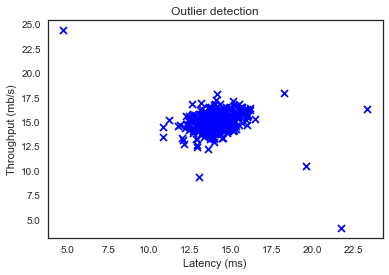

In [4]:
plt.scatter(X[:,0], X[:,1], c='b', marker='x')
plt.title("Outlier detection")
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)');

In [5]:
def estimate_gaussian(X):
    return X.mean(axis=0), np.cov(X.T)

In [6]:
mu, sigma2 = estimate_gaussian(X)

In [7]:
def mva_gaussian( X, mu, sigma2 ):
    k = len(mu)
    # check if sigma2 is a vector and, if yes, use as the diagonal of the covariant matrix
    if sigma2.ndim == 1 :
        sigma2 = np.diag(sigma2)
    X = X - mu
    return (2 * np.pi)**(-k/2) * np.linalg.det(sigma2)**(-0.5) * \
        np.exp( -0.5 * np.sum( np.multiply( X.dot( np.linalg.inv(sigma2) ), X ), axis=1 ) ).reshape( ( X.shape[0], 1 ) )

In [8]:
# Check dimensionality
p = mva_gaussian(X,mu, sigma2)
print(p.shape)

(307, 1)


In [9]:
def visualize_fit( X, mu, sigma2 ):
    x = y = np.arange( 0, 30, 0.5 )
    xx, yy = np.meshgrid( x, y )
    z = mva_gaussian( np.vstack( (xx.ravel(), yy.ravel()) ).T, mu, sigma2 )
    z = z.reshape( xx.shape )
    levels = [ 10**a for a in range(-20, 0, 3) ]
    plt.contour( xx, yy, z, levels=levels )

In [22]:
def plot_data(X):   
    plt.scatter(X[:,0], X[:,1], c='b', marker='x')
#     plt.plot(X[:,0], X[:,1], 'bx', markersize = 3.5 )
    plt.axis([0,30,0,30])
    plt.xlabel( 'Latency (ms)' )
    plt.ylabel( 'Throughput (mb/s)' )

Text(0.5,1,'Gaussian fit (diagonal covariance matrix)')

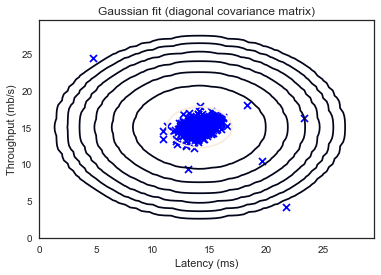

In [24]:
plot_data(X)
visualize_fit(X, mu , np.diag( sigma2) )
plt.title( 'Gaussian fit (diagonal covariance matrix)' )

Text(0.5,1,'Multivariate Gaussian fit')

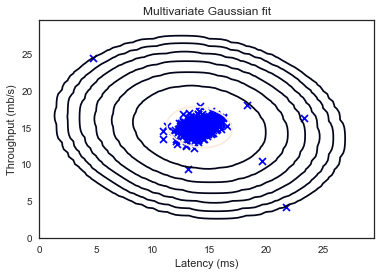

In [26]:
plot_data(X)
visualize_fit(X, mu , sigma2)
plt.title('Multivariate Gaussian fit')

In [27]:
def select_threshold( yval, pval ):
    best_Epsilon = 0
    best_F1 = 0
    
    for eps in np.linspace( np.amin(pval), np.amax(pval), 1000 ):
        cv_predictions = pval < float(eps)

        if len( cv_predictions ) < 1:
            continue
            
        tp = np.sum( np.logical_and( (cv_predictions == 1), (yval == 1) ) )
        fp = np.sum( np.logical_and( (cv_predictions == 1), (yval == 0) ) )
        fn = np.sum( np.logical_and( (cv_predictions == 0), (yval == 1) ) )

        prec = tp/(tp + fp)
        rec = tp/(tp + fn)
        F1 = (2 * prec * rec) / ( prec + rec )
        if F1 > best_F1:
            best_F1 = F1
            best_Epsilon = float(eps)

    return best_Epsilon, best_F1

In [31]:
pval = mva_gaussian( Xval, mu, sigma2 )

In [34]:
epsilon, f1 = select_threshold(yval, pval )


/Users/nishant/venv/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in long_scalars
  from ipykernel import kernelapp as app


In [35]:
outliers = mva_gaussian(X, mu, sigma2 )[:,0] < epsilon

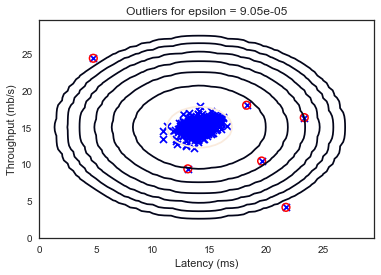

In [38]:
width = 1
precision = 3
plot_data(X)
visualize_fit(X, mu , np.diag( sigma2) )
plt.title( f'Outliers for epsilon = {epsilon:{width}.{precision}}' ) # python 3.6 formatted string literals
plt.scatter( X[outliers][:,0], X[outliers][:,1], s=60, edgecolors='r', facecolors='None', linewidth=1.5 )

In [39]:
hd_data = loadmat('data/ex8data2.mat')
hd_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])

In [40]:
mu_hd, sigma2_hd = estimate_gaussian( hd_data['X'] )


In [41]:
p_hd = mva_gaussian( hd_data['X'], mu_hd, np.diag(sigma2_hd) )


In [42]:
pval_hd = mva_gaussian( hd_data['Xval'], mu_hd, np.diag(sigma2_hd) )


In [43]:
epsilon_hd, f1_hd = select_threshold(hd_data['yval'], pval_hd)


/Users/nishant/venv/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in long_scalars
  from ipykernel import kernelapp as app


In [44]:
print( 'Best epsilon found using cross-validation: ', epsilon_hd )
print( 'Best F1 on Cross Validation Set:', f1_hd )
print( '# of outliers found: ', np.sum( p_hd < epsilon_hd ) )

Best epsilon found using cross-validation:  1.3730337086887016e-18
Best F1 on Cross Validation Set: 0.615384615385
# of outliers found:  117


# 2. Recommendation System

In [46]:
movies_data = loadmat('data/ex8_movies.mat')
movies_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Y', 'R'])

In [47]:
print(movies_data)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Thu Dec  1 17:19:26 2011', '__version__': '1.0', '__globals__': [], 'Y': array([[5, 4, 0, ..., 5, 0, 0],
       [3, 0, 0, ..., 0, 0, 5],
       [4, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), 'R': array([[1, 1, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}


In [49]:
print('Average rating for movie 1 (Toy Story): ', round( np.mean( movies_data['Y'][0][movies_data['R'][0].astype(bool)] ), 2 ))

Average rating for movie 1 (Toy Story):  3.88


Text(0,0.5,'Movies')

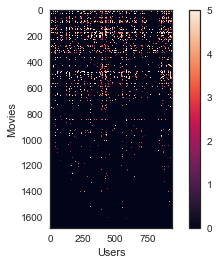

In [50]:

# We can "visualize" the ratings matrix by plotting it with imagesc# We can 
plt.imshow( movies_data['Y'] )
plt.colorbar()
plt.xlabel('Users')
plt.ylabel('Movies')